# Explore here

In [1]:
!pip install missingno lazypredict
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [3]:
df=pd.read_csv('/workspaces/EDA/data/raw/AB_NYC_2019.csv')
pd.set_option('display.max_columns', None)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
# Dimensiones del DF
df.shape

(48895, 16)

EL dataframe contiene 48.895 filas y 16 varibles

In [ ]:
# vemos el tipo de cada columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Obtenemos 8 variables categoricas y 8 numéricas

In [ ]:
#Revismaos si hay anuncios duplicados
df.duplicated().sum()

np.int64(0)

No hay anuncios duplicados


In [ ]:
#Comprobamos si hay valores únicos en las columnas
n_unicos = df.nunique()
n_unicos

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

No hay ninguna variable que sea constante o tenga valor único

<Axes: >

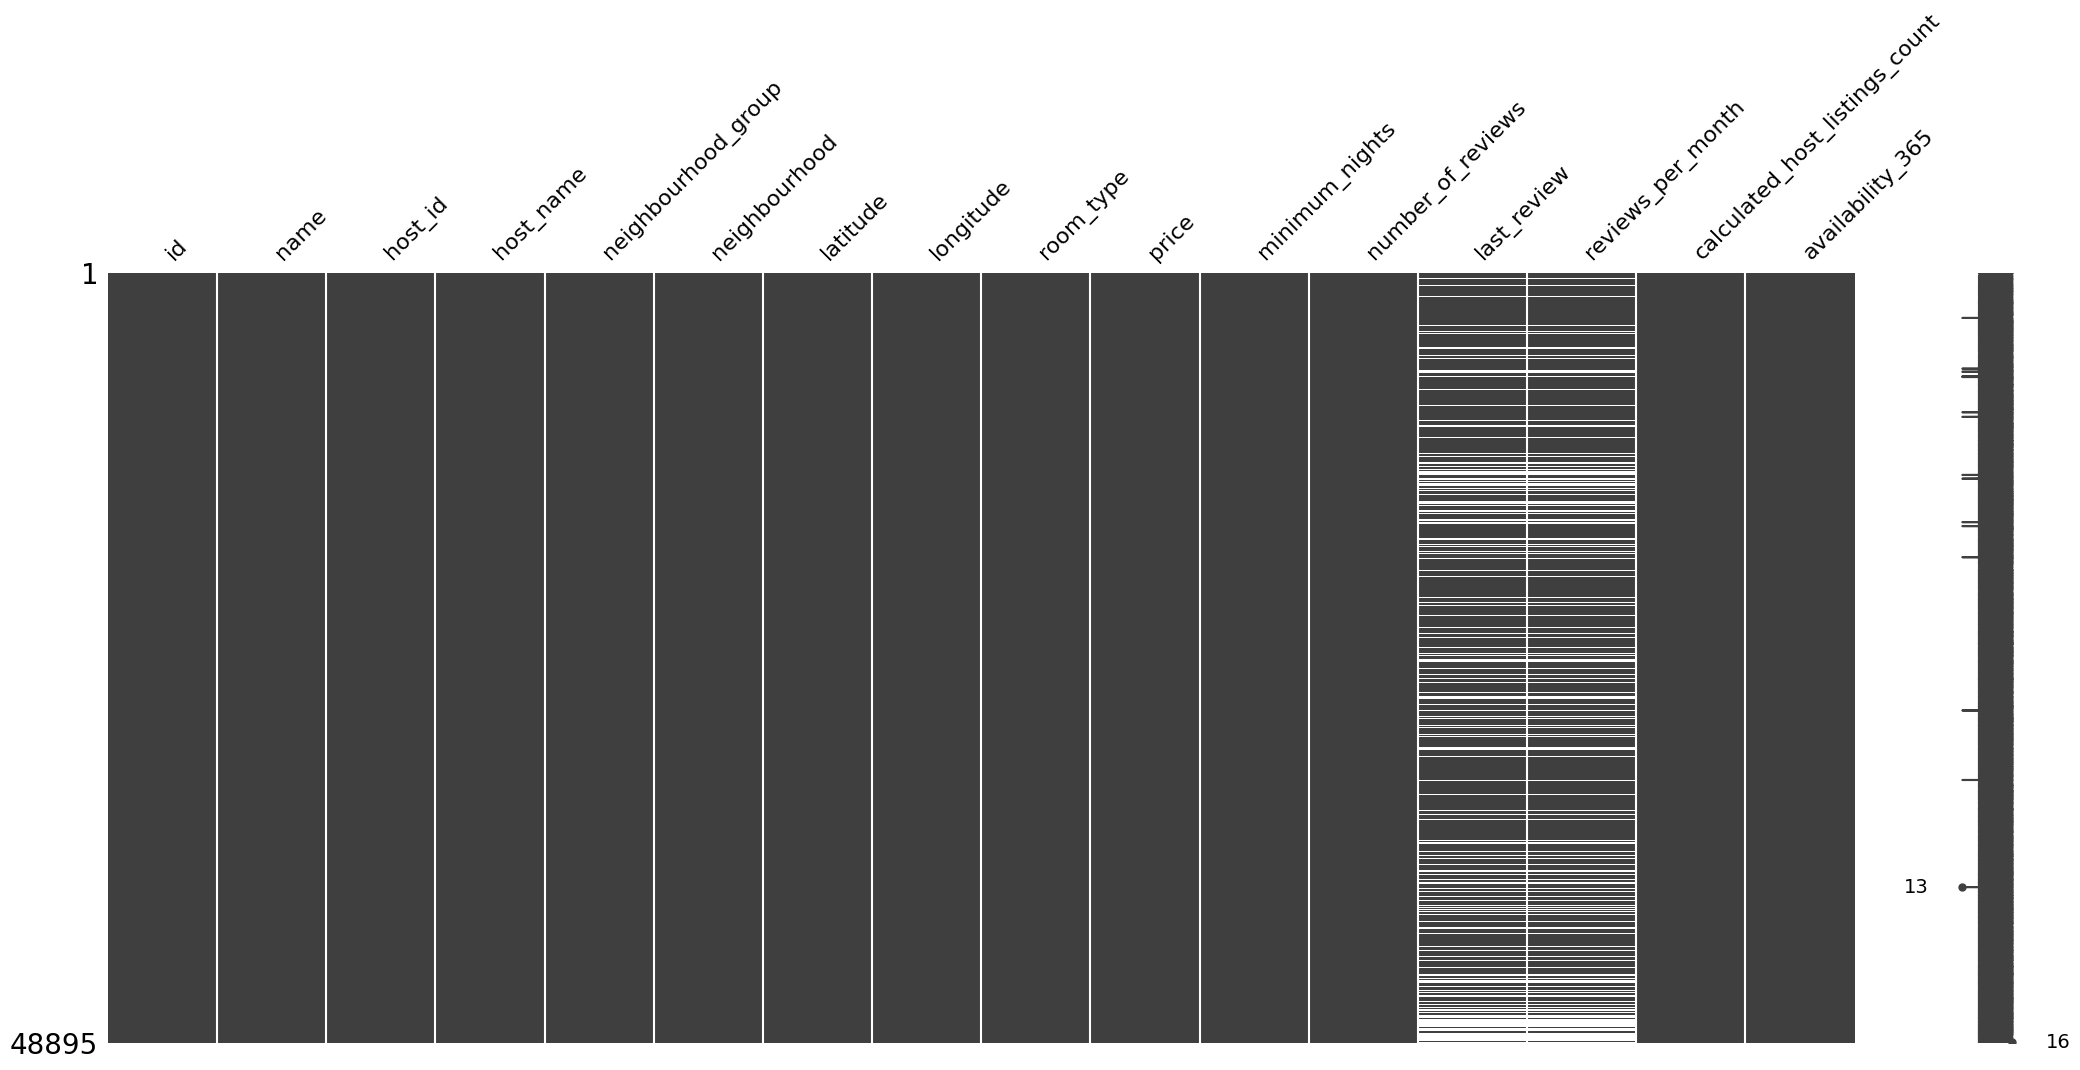

In [8]:
msno.matrix(df)

Observamos que tenemos valores faltantes en las columbas the last_review y reviews_per_month, y que existe un patrón entre ellas al encontrarse los valores faltantes en ambas columnas en las mismas filas. Esto lo vemos por la altura en la que parecen los espacios en blanco.

In [9]:
# ELiminiamos las columnas que no nos apostan informacion relevante
df.columns
df.drop (['name','id','host_name','last_review','reviews_per_month'] , axis=1, inplace= True)
df.shape

(48895, 11)

Elimino las columnas de "last_review" y "reviews_per_month" para evitar redundancia con la variable number_of_reviews.

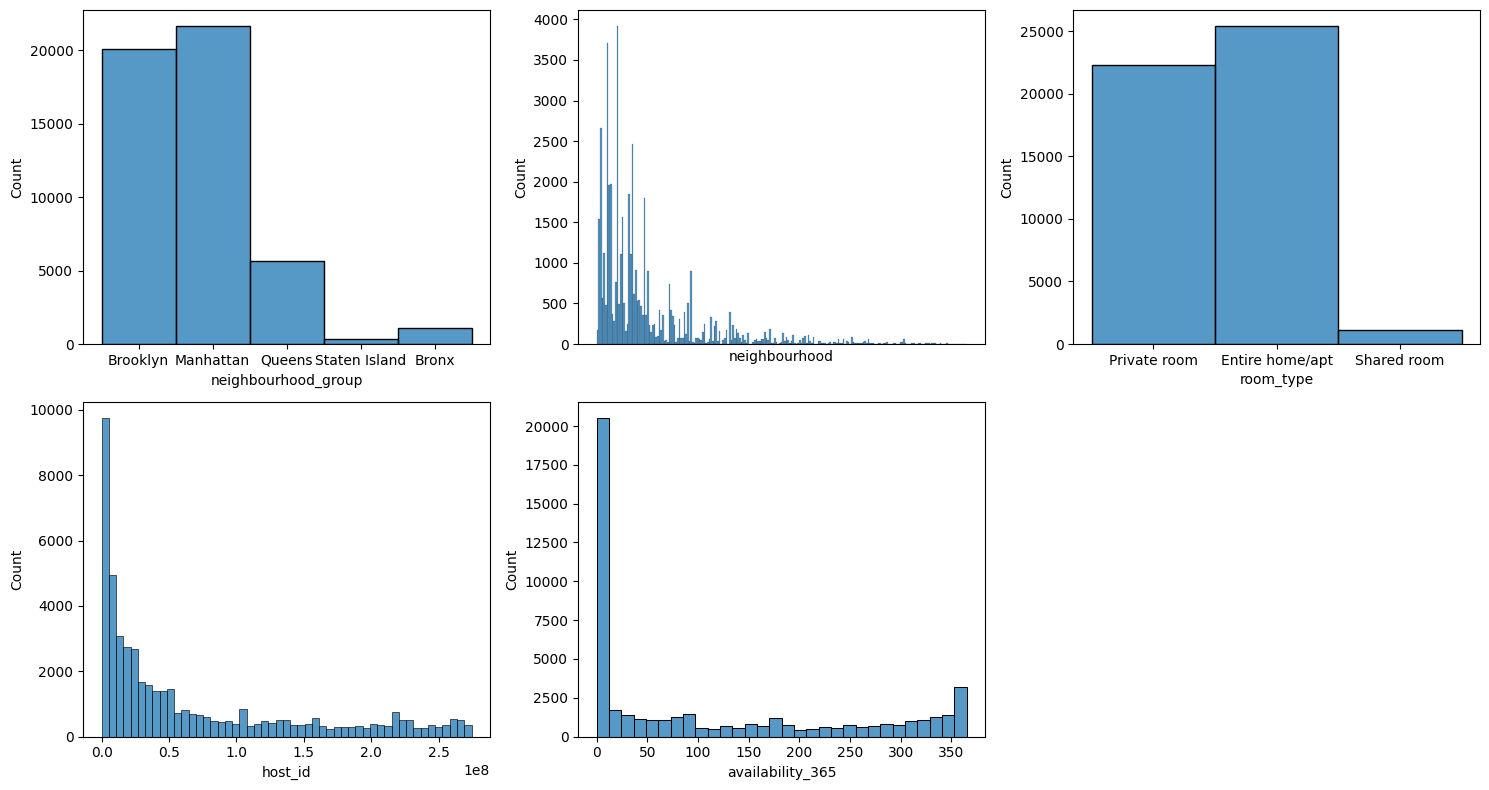

In [10]:
# Análisis Univariante de variables categoricas 

fig, axis = plt.subplots(2, 3, figsize = (15, 8))
fig.delaxes(axis[1,2])

# Crear un histograma múltiple
sns.histplot(ax = axis[0, 0], data = df, x = "neighbourhood_group")
sns.histplot(ax = axis[0, 1], data = df, x = "neighbourhood", bins=5).set_xticks([])
sns.histplot(ax = axis[0, 2], data = df, x = "room_type")
sns.histplot(ax = axis[1, 0], data = df, x = "host_id")
sns.histplot(ax = axis[1, 1], data = df, x = "availability_365")


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

Sacamos la siguiente información de los histogramas:
- Tenemos 5 distritos de la ciudad de Nueva York
- Los distritos con más oferta son  Manhattan y brooklyn. En contraposición los distritos de Staten Island y el Bronx son los que menos oferta tienen.
- EStán en alquiler muchos más apartamentos completos o habitaciones privadas, que habitaciones compartidas. No sabemos si esta diferencia se debe a que enen una alta demanda o una baja oferta.
- En cuanto a la gráfica de host_id vemos que tenemos muchos valores a 0, y que hay propietarios que tienen muchas habitaciones para alquilar
- En cuanto a la disponibilidad, podemos decir que la mayoría de las habiaciones están disponibles todo el año. Nos llama la atención la gran cantidad de 0 que presenta esta variable. 

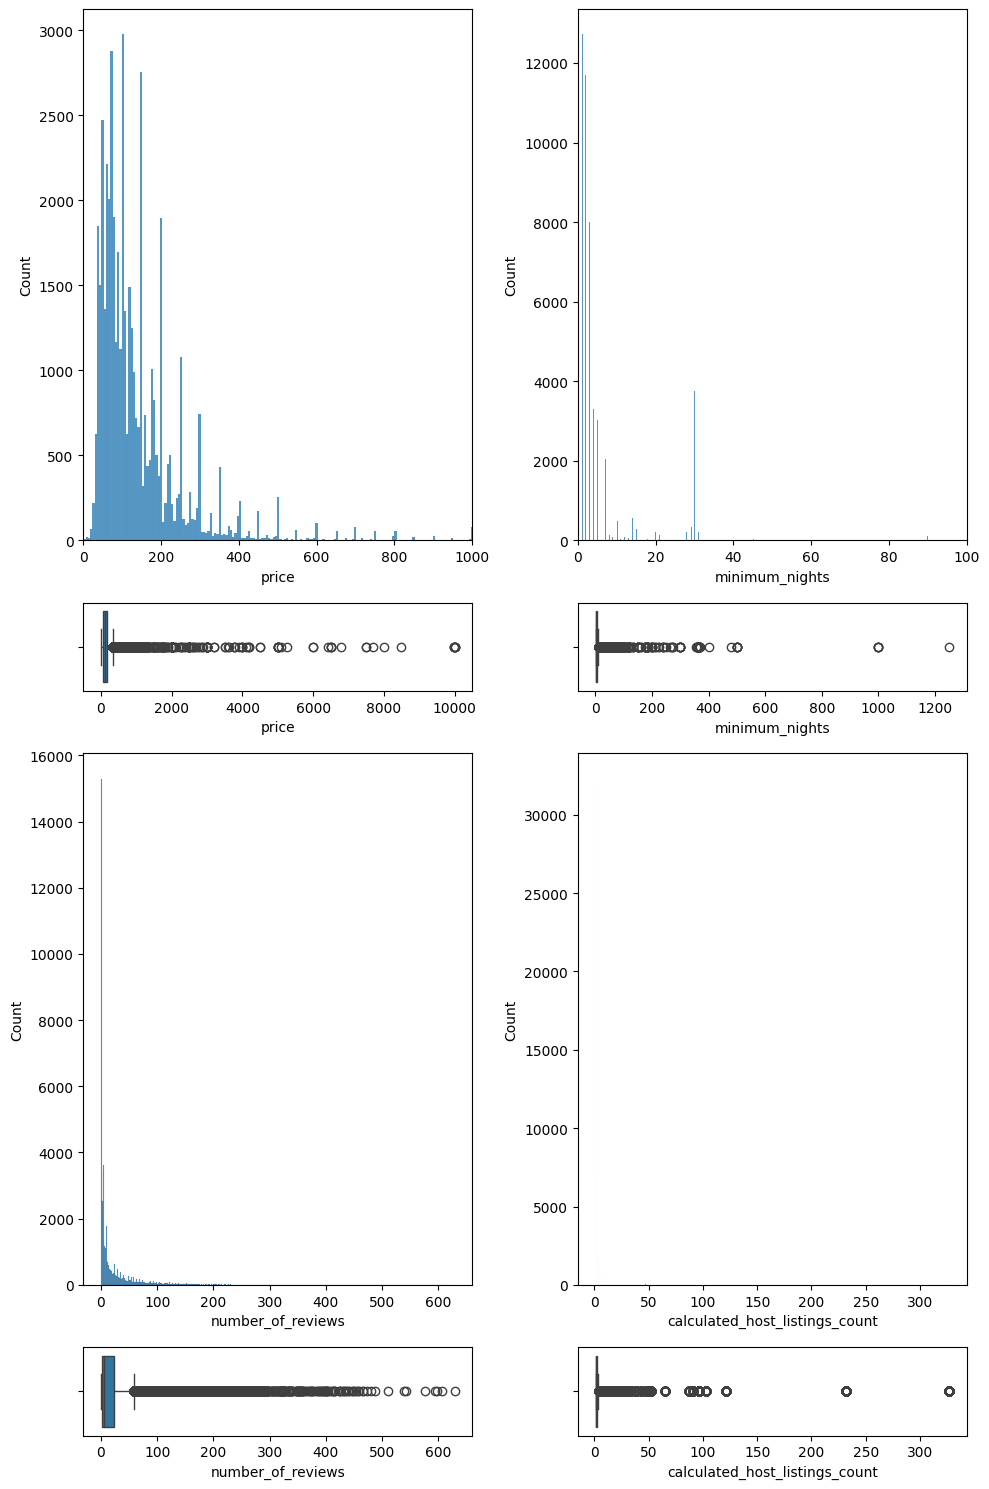

In [11]:
#Análisis de variables Univariante númericas
fig, axis = plt.subplots(4, 2, figsize = (10, 15) ,gridspec_kw = {"height_ratios": [6, 1, 6, 1]})
                      
sns.histplot(ax = axis[0, 0], data = df, x = "price").set_xlim (0,1000)
sns.boxplot(ax = axis[1, 0], data = df, x = "price")
sns.histplot(ax = axis[0, 1], data = df, x = "minimum_nights").set_xlim(0,100)
sns.boxplot(ax = axis[1, 1], data = df, x = "minimum_nights")
sns.histplot(ax = axis[2, 0], data = df, x = "number_of_reviews")
sns.boxplot(ax = axis[3, 0], data = df, x = "number_of_reviews")
sns.histplot(ax = axis[2, 1], data = df, x = "calculated_host_listings_count")
sns.boxplot(ax = axis[3, 1], data = df, x = "calculated_host_listings_count")

plt.tight_layout()
plt.show()

Con las gráficas sacamos la siguiente información:
- EL precio de la mayoria de habitaciones se encuentra por debajo de los 200€. Hay valores cercanos a 0 o nulos (más adelante lo comprobaremos)
- La mayoría de los datos sobre la estancia mínima se encuentra entre 1 y 7 noches.
- Hay muchos valores nulos o faltantes en el número de reseñas

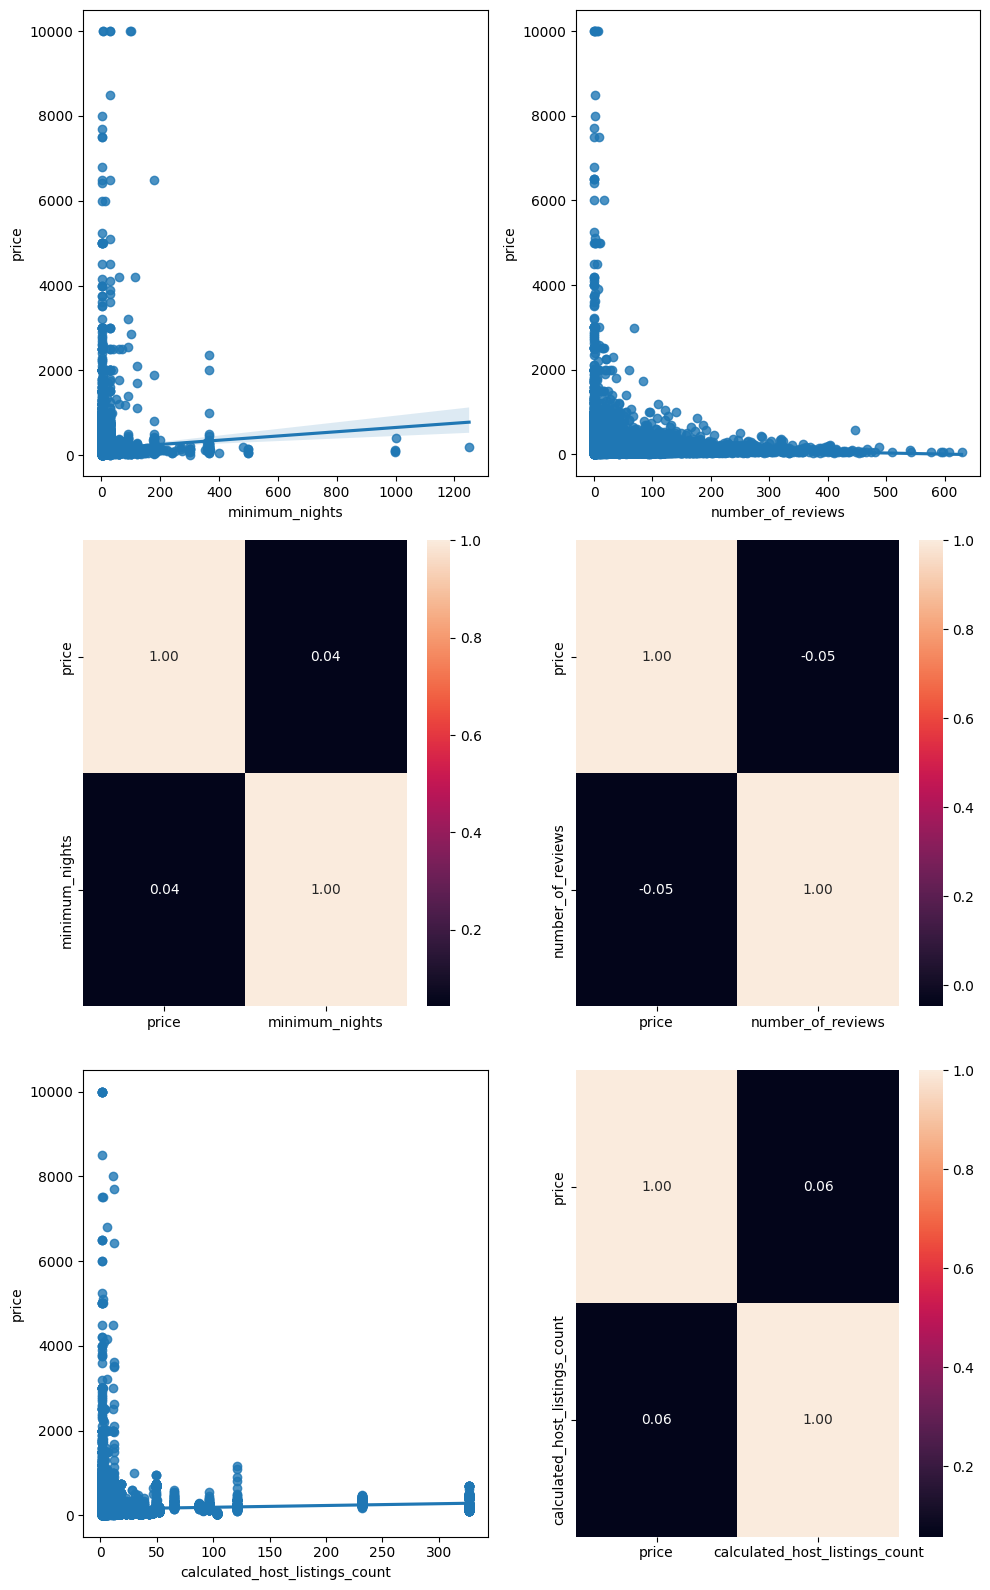

In [12]:
# Análisis de variables multivariadas
## NUmérico-Numérico

fig, axis = plt.subplots(3, 2, figsize = (10, 16))

sns.regplot(ax = axis[0, 0], data = df, x = "minimum_nights", y = "price")
sns.heatmap(df[["price", "minimum_nights"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0])

sns.regplot(ax = axis[0, 1], data = df, x = "number_of_reviews", y = "price")
sns.heatmap(df[["price", "number_of_reviews"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = df, x = "calculated_host_listings_count", y = "price")
sns.heatmap(df[["price", "calculated_host_listings_count"]].corr(), annot = True, fmt = ".2f", ax = axis[2, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

De las gráficas anteriores podemos ver que no existe relación entre el precio y el número de noches, ni entre el precio y el número de reseñas.

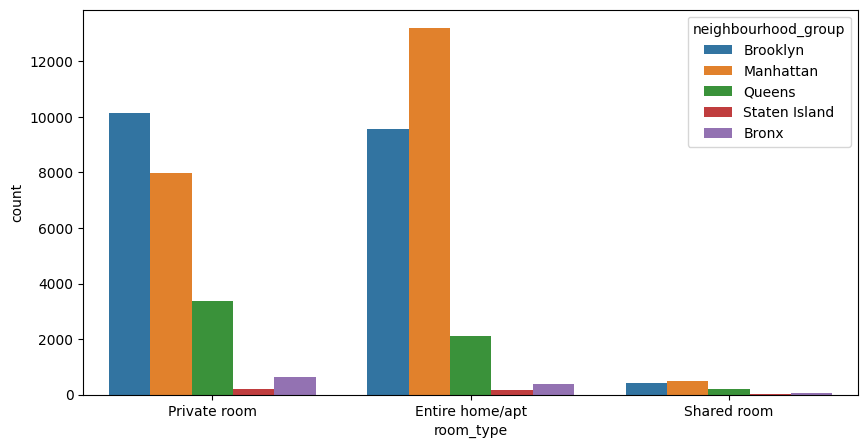

In [13]:
## Análisis categortico-categórico
fig, axis = plt.subplots(figsize = (10, 5))

sns.countplot(data = df, x = "room_type", hue = "neighbourhood_group")

plt.show()

De la grafica anterior, sacamos la siguiente informacióin:
- Las habitaciones compartidas en todos los estados tienen una baja oferta.
- La oferta en brooklyn la lidera la habitaciín privada, muy seguida de cera del apartamento completo
- En Manhattan la oferta se centra principalente en apartamentos completos, seguido de habitaciones privadas.
- En el resto de estados la oferta se reduce significativamente independientemente del tipo de alojamiento.

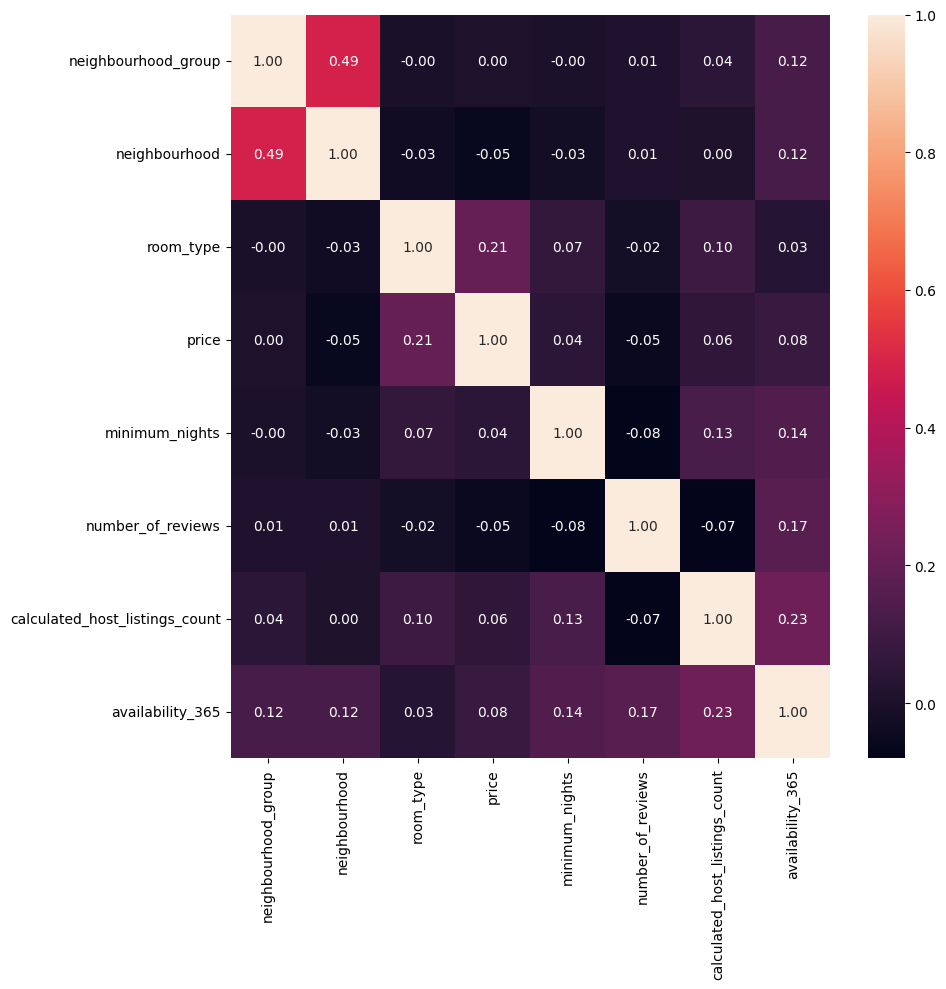

In [14]:
## Análisis numérico categórico completo
# Factorizamos las variables room type, Neighbourhoog ty Neighbourhood group y graficamos
df["neighbourhood_group"] = pd.factorize(df['neighbourhood_group'])[0]
df["room_type"] = pd.factorize(df["room_type"])[0]
df["neighbourhood"]= pd.factorize(df["neighbourhood"])[0]

fig, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(df[["neighbourhood_group", "neighbourhood", "room_type", "price", "minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()
plt.show()


En el gráfico anterior observamos lo siguiente:
- La correlacíon más alta se encuentra entre neighbourhood y neighbourhood group, lo que tiene sentido porque en vecindario está dentro del grupo de vecindarios.
- Existe correlación positiva entre el precio y el tipo de habitación. ES decir que una aumenta cuando aumenta la otra.

A pesar de que exista correlación, en ninguno de los casos es muy significativa.

In [15]:
#Descripción de las columnas numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
host_id,48895.00,67620010.65,78610967.03,2438.00,7822033.00,30793816.00,107434423.00,274321313.00
neighbourhood_group,48895.00,0.79,0.84,0.00,0.00,1.00,1.00,4.00
neighbourhood,48895.00,29.89,34.68,0.00,7.50,19.00,37.00,220.00
latitude,48895.00,40.73,0.05,40.50,40.69,40.72,40.76,40.91
longitude,48895.00,-73.95,0.05,-74.24,-73.98,-73.96,-73.94,-73.71
room_type,48895.00,0.57,0.54,0.00,0.00,1.00,1.00,2.00
price,48895.00,152.72,240.15,0.00,69.00,106.00,175.00,10000.00
minimum_nights,48895.00,7.03,20.51,1.00,1.00,3.00,5.00,1250.00
number_of_reviews,48895.00,23.27,44.55,0.00,1.00,5.00,24.00,629.00
calculated_host_listings_count,48895.00,7.14,32.95,1.00,1.00,1.00,2.00,327.00


In [16]:
# Revisamos si hay valores faltantes
df.isnull().mean()*100

host_id                          0.00
neighbourhood_group              0.00
neighbourhood                    0.00
latitude                         0.00
longitude                        0.00
room_type                        0.00
price                            0.00
minimum_nights                   0.00
number_of_reviews                0.00
calculated_host_listings_count   0.00
availability_365                 0.00
dtype: float64

In [17]:
# Identificar observaciones influyentes
X = df.drop(['price'], axis = 1)
y = df['price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
cooks_distance = model.get_influence().cooks_distance

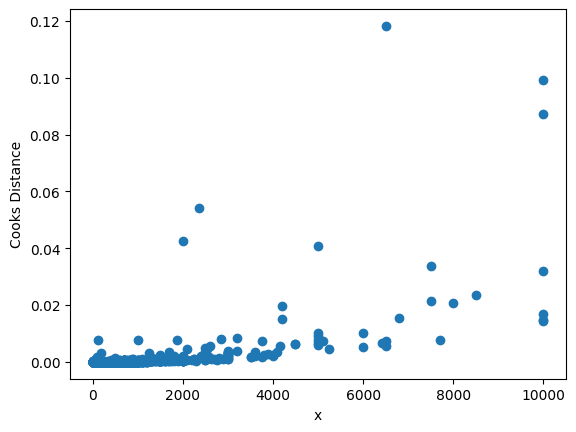

In [18]:
plt.scatter(df['price'], cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [19]:
# Punto de corte para la distancia de cook
pto_corte = 4/len(df)

# Viviendas por encima del pto de corte
len(np.where(cooks_distance[0]>pto_corte)[0])

700

In [20]:
np.where(cooks_distance[0]>0.11)

(array([48043]),)

In [22]:
# Vemos los datos de nuestro punto más alejado 

df.iloc[48043,]

host_id                          271248669.00
neighbourhood_group                      1.00
neighbourhood                           77.00
latitude                                40.71
longitude                              -74.01
room_type                                1.00
price                                 6500.00
minimum_nights                         180.00
number_of_reviews                        0.00
calculated_host_listings_count           1.00
availability_365                       365.00
Name: 48043, dtype: float64

In [21]:
# Eliminar observaciones que se consideran influentes
df_influyente = df.drop(np.where(cooks_distance[0]>pto_corte)[0])

In [23]:
#Comprobamos si hay duplicados
df_influyente.duplicated().sum()

np.int64(0)

In [24]:
#Separamos las variables independientes de la dependiente
X = df_influyente.drop(['price'], axis = 1)
y = df_influyente['price']

In [26]:
#Partición de los datos en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Selección de características
## Importancia de las variables

# Usamos xgb para conocer la importancia de las características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_influyente = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_influyente = df_influyente.sort_values(by='Importance', ascending=False)
df_influyente

,Feature,Importance
5,room_type,61.60
4,longitude,7.56
8,calculated_host_listings_count,5.58
3,latitude,5.04
6,minimum_nights,4.53
9,availability_365,4.07
2,neighbourhood,3.66
7,number_of_reviews,3.53
0,host_id,2.61
1,neighbourhood_group,1.83


In [31]:
df_influyente[df_influyente.Importance>1]['Feature'].values

array(['room_type', 'longitude', 'calculated_host_listings_count',
       'latitude', 'minimum_nights', 'availability_365', 'neighbourhood',
       'number_of_reviews', 'host_id', 'neighbourhood_group'],
      dtype=object)

In [32]:
# Seleccionamos las características que presentan más de un 1% de importancia
X_train = X_train[df_influyente[df_influyente.Importance>1]['Feature'].values]
X_test = X_test[df_influyente[df_influyente.Importance>1]['Feature'].values]